# Divide ROI with gene expression data
This notebook divide ROIs using gene expression data of Allen Institute for Brain Science (AIBS). In this example, we used a gene, Wfs1, to divide CA1 region of the hippocampus. Wfs1 is expressed dominantly at dorsal part of CA1 in the hippocampus.

- input
    - ExpID (74881161 for Wfs1 gene)
    - Target_ROI_ID (382 for hippocampal CA1)
    - AVbase_c.nrrd
- output
    - annotation volume with gene-expression dependent division of targeted ROI
    - figures that demonstrate the ROI division

In [1]:
# user-specified data
ExpID = 74881161 # Wfs1 is highly expressed in CA1 of the dorsal hippocampus
Target_ROI_ID = 382 # 382 is hippocampal CA1 

dir_data = 'data'
dir_fig = 'figs'
# dir_gene = 'gene_data\\' + str(ExpID) + '\\'
dir_gene = 'gene_data\\74881161\\'
# The last \\ is necessary for windows PC to download data into the folder.
# Otherwise, just link for the data is returnened.

fn_input_AV = 'AVbase_c.nrrd'

In [2]:
fn_output_AV_target_ROI_gene_HighLow =\
    'AV_target_ROI_ID_'+str(Target_ROI_ID)+'_gene_'+str(ExpID)+'.nrrd'
fn_output_fig_gene_expression = 'gene_'+str(ExpID)+'.png'
fn_output_fig_target_ROI = 'target_ROI_'+str(Target_ROI_ID)+'.png'
fn_output_fig_gene_expression_in_target_ROI =\
    'gene_in_target_ROI_'+str(ExpID)+'_'+str(Target_ROI_ID)+'.png'
fn_output_fig_histogram_gene = 'gene_histogram_'+str(ExpID)+'.png'
fn_output_fig_divided_ROI_gene = 'divided_ROI_gene_'+str(ExpID)+'.png'

In [3]:
import os
from allensdk.api.queries.grid_data_api import GridDataApi
import glob
import pandas as pd
from pprint import pprint
import numpy as np
import nrrd
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
from skimage import transform
from scipy import optimize
%matplotlib inline

VolumeType = 'energy.mhd' # {energy, density, intensity}
# just used for displaying data
SliceIdx = 84
CoronalIdx = np.linspace(71,84,3)

# Load data

In [4]:
AV, header = nrrd.read(os.path.join(dir_data, fn_input_AV))
# uint32, [132, 80, 114] = (AP, SI, LR) = PIR
AV_targetROI = AV == Target_ROI_ID

gda = GridDataApi()
gda.download_gene_expression_grid_data(ExpID, GridDataApi.ENERGY, os.path.join(dir_gene))

img_gene = io.imread(os.path.join(dir_gene, VolumeType), plugin='simpleitk')
# 200 um iso-voxel, voxels (58,41,67) = (LR, SI, AP) = RIP
img_gene_tr = np.ndarray.transpose(img_gene)
img_gene_tr_resized = skimage.transform.resize(img_gene_tr, AV_targetROI.shape, preserve_range=True)
# adjusting img_gene size and orientation to that of AV

img_gene_only_in_targetROI = img_gene_tr_resized * AV_targetROI

FileNotFoundError: [Errno 2] No such file or directory: 'data\\AVbase_c.nrrd'

# Check loaded data

## Gene expression

Experimental ID:74881161
Coronal indices: [71. 78. 84.]


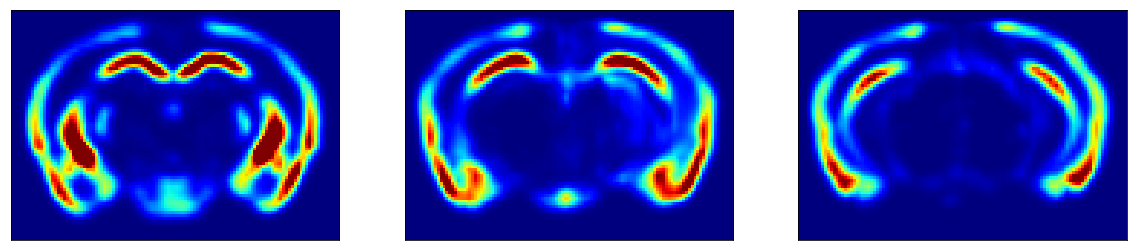

In [17]:
print('Experimental ID:'+str(ExpID))
print('Coronal indices: '+str(CoronalIdx.round()))

slices = [int(x) for x in CoronalIdx.round()]
fig1, ax1 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H1 = ax1[count].imshow(img_gene_tr_resized[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=20)
    ax1[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
#fig1.colorbar(H4, ticks=v, fraction=0.033, pad=0.04)
# gene volume: 200 um iso. 67 slices; -> 100 um iso, ~134 slices, AP [71,78,84] slices
# AP [36, 40, 43] in 67 slices; [71, 78, 84] in ~134 slices
# -> 134 - [36, 40, 43] = [63, 56, 50]th slices in P2A direction in 100 um iso.
# -> bregma 78 - [63, 56, 50] = ### [15, 22, 28] * 100 um posterior. for gene images ###
# AV: 100 um iso, 132 slices PtoA, bregma at 78th slice


## Target ROI

Target ROI ID: 382


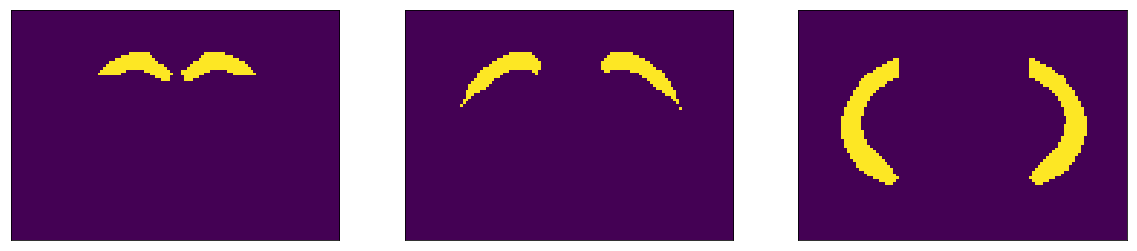

In [18]:
print('Target ROI ID: '+str(Target_ROI_ID))

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

fig2, ax2 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    ax2[count].imshow(AV_targetROI[idx,:,:], aspect='equal')
    ax2[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

## Merge gene expression and target ROI

Gene expression only in the target ROI
Experimental ID:74881161


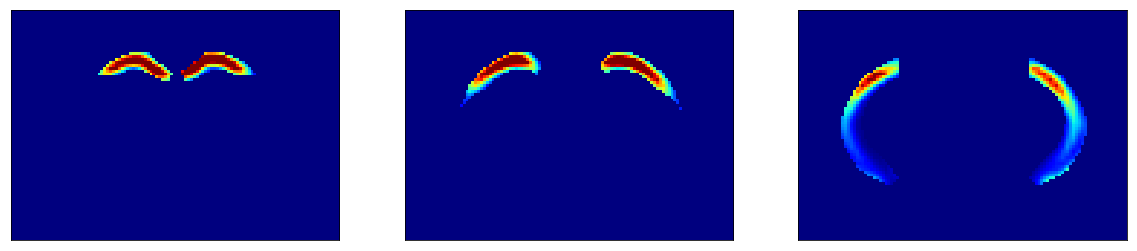

In [19]:
# AV_targetROI[84, 40, 20 ] # True
# plt.imshow(img_gene_onlyCA1[84,:,:])
print('Gene expression only in the target ROI')
print('Experimental ID:'+str(ExpID))

fig3, ax3 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H3 = ax3[count].imshow(img_gene_only_in_targetROI[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=20)
    ax3[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

# Plot histogram of gene expression data in a target ROI

In [20]:
hist, bin_edges = np.histogram(img_gene_only_in_targetROI[img_gene_only_in_targetROI != 0],\
                               bins=30)

## Fit with two log-normal distribution

In [21]:
center_ind = (bin_edges[:-1] + bin_edges[1:])/2

def LogNormal(x, height, center, width, offset):
    return height*np.exp(-(np.log(x) - center)**2/(2*width**2))/x + offset
def two_LogNormal(x, h1, c1, w1, h2, c2, w2, offset):
    return (LogNormal(x, h1, c1, w1, offset=0) + LogNormal(x, h2, c2, w2, offset=0) + offset)
errfunc1 = lambda p, x, y: (LogNormal(x, *p) - y)#**2
errfunc2 = lambda p, x, y: (two_LogNormal(x, *p) - y)#**2
guess1 = [1200, 3, 2, 100]
guess2 = [1200, 3, 1, 300, 15, 5, 0]
optim1, success1 = optimize.leastsq(errfunc1, guess1[:], args=(center_ind, hist))
optim2, success2 = optimize.leastsq(errfunc2, guess2[:], args=(center_ind, hist))

# get intersection of two fitting functions
eval_func = lambda x: (LogNormal(x, *optim2[0:3], optim2[-1]) - LogNormal(x, *optim2[3:6], 0))
ini_x1 = 0.5
ini_x2 = 30
for i in range(30):
    half = (ini_x1 + ini_x2) / 2
    val = eval_func(half)
    if val > 0:
        ini_x1 = half
    else:
        ini_x2 = half
Thr_gene = (ini_x1 + ini_x2)/2

## plot histogram of gene expression in a target ROI

ID of a target ROI: 382
Experimental ID for gene expression: 74881161
Threshold for gene expression: 11.1


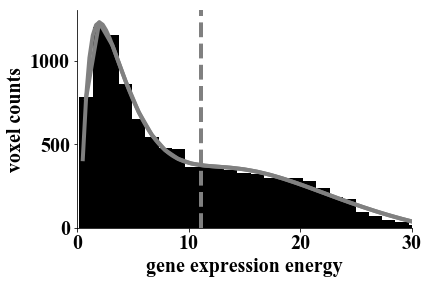

In [22]:
print('ID of a target ROI: '+str(Target_ROI_ID))
print('Experimental ID for gene expression: '+str(ExpID))
print('Threshold for gene expression: %2.1f' % Thr_gene)

fig4, ax4 = plt.subplots(facecolor='w')
ax4.bar(center_ind, hist, width = 1.2, color='black') # energy data
# ax4.plot(center_ind, LogNormal(center_ind, *optim2[0:3], optim2[-1]), lw=4, c='r', ls='-')
# ax4.plot(center_ind, LogNormal(center_ind, *optim2[3:6], 0), lw=4, c='c', ls='-')
# ax4.plot(center_ind,two_LogNormal(center_ind, *optim2), lw=4, c='gray', ls='-') # doubne log normal fit
ax4.plot(np.linspace(0.5,30,100),two_LogNormal(np.linspace(0.5,30,100), *optim2), lw=4, c='gray', ls='-') # doubne log normal fit
ax4.axvline(x=Thr_gene, color='gray', linewidth=4, linestyle='--', label='inflection')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')
ax4.set_xlim(0,30)
ax4.set_ylim(0,1300)
ax4.set_xlabel('gene expression energy')
ax4.set_ylabel('voxel counts');

# Divide a target ROI with gene expression data

In [23]:
img_gene_only_in_targetROI_High = (img_gene_only_in_targetROI >= Thr_gene)\
* (img_gene_only_in_targetROI - Thr_gene)

img_gene_only_in_targetROI_Low = (img_gene_only_in_targetROI < Thr_gene)\
* (img_gene_only_in_targetROI != 0) * (img_gene_only_in_targetROI - Thr_gene)

img_gene_HighLow = img_gene_only_in_targetROI_High + img_gene_only_in_targetROI_Low

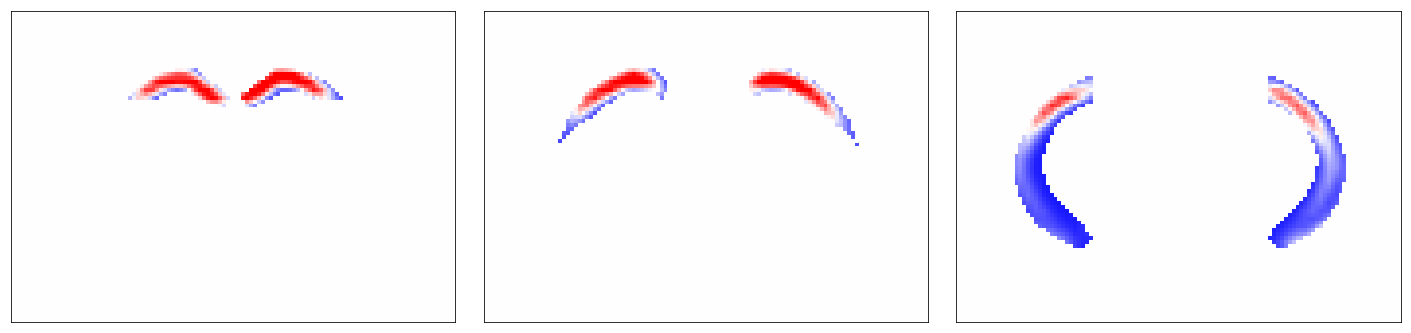

In [24]:
fig5, ax5 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H5 = ax5[count].imshow(img_gene_HighLow[idx,:,:], aspect='equal',\
                           cmap='bwr', vmin=-12, vmax=12)
    ax5[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
fig5.tight_layout()
# cb = fig5.colorbar(H5, fraction=0.046, pad=0.04)
# cb.outline.set_visible(False)
# cb.set_ticks([])

# Save

## figures

In [25]:
fig1.savefig(os.path.join(dir_fig, fn_output_fig_gene_expression),\
           dpi=300, bbox_inches='tight')

fig2.savefig(os.path.join(dir_fig, fn_output_fig_target_ROI),\
           dpi=300, bbox_inches='tight')

fig3.savefig(os.path.join(dir_fig, fn_output_fig_gene_expression_in_target_ROI),\
           dpi=300, bbox_inches='tight')

fig4.savefig(os.path.join(dir_fig, fn_output_fig_histogram_gene),\
           dpi=300, bbox_inches='tight')

fig5.savefig(os.path.join(dir_fig, fn_output_fig_divided_ROI_gene),\
           dpi=300, bbox_inches='tight')

## AV that contains a ROI that highly expresses a gene, and a ROI that  express a gene little.

In [26]:
nrrd.write(os.path.join(dir_data, fn_output_AV_target_ROI_gene_HighLow),\
           img_gene_HighLow, header)
           